In [ ]:
pip install tensorflow numpy pandas


Loading the datasets

In [ ]:
import pandas as pd
# Load the datasets
data_df = pd.read_csv('data.csv')
index_df = pd.read_csv('index.csv')

# Display the first few rows of each dataframe
print(data_df.head())
print(index_df.head())


   relative_time_second  number_of_followers
0                   0.0                   33
1               84833.0                46828
2               84878.0                  208
3               84883.0                   37
4               84900.0                  137
       tweet_id  post_time_day  start_ind  end_ind
0  1.224346e+17       0.926644          1      175
1  1.224497e+17       0.968160        176      369
2  1.224502e+17       0.969560        370      703
3  1.224430e+17       0.949734        704      827
4  1.224566e+17       0.987373        828      941


Assigning Start and End Indices

In [ ]:
# Print the datasets to verify their contents
print("data_df:\n", data_df.head())
print("index_df:\n", index_df.head())

# Print lengths of the datasets
len_data = len(data_df)
len_index = len(index_df)

print(f"Length of data_df: {len_data}, Length of index_df: {len_index}")

# Check if the lengths match and handle accordingly
if len_data <= len_index:
    # Truncate index_df to match the length of data_df
    relevant_index_df = index_df.iloc[:len_data].copy()

    # Assign start_ind and end_ind to data_df
    data_df['start_ind'] = relevant_index_df['start_ind'].values
    data_df['end_ind'] = relevant_index_df['end_ind'].values

    # Calculate cascade size
    data_df['cascade_size'] = data_df['end_ind'] - data_df['start_ind'] + 1

    # Features and labels
    X = data_df[['relative_time_second', 'number_of_followers']]
    y = data_df['cascade_size']

    # Check the results
    print("Features:\n", X.head())
    print("Labels:\n", y.head())
else:
    print("data_df is longer than index_df; manual adjustments may be needed.")


data_df:
    relative_time_second  number_of_followers
0                   0.0                   33
1               84833.0                46828
2               84878.0                  208
3               84883.0                   37
4               84900.0                  137
index_df:
        tweet_id  post_time_day  start_ind  end_ind
0  1.224346e+17       0.926644          1      175
1  1.224497e+17       0.968160        176      369
2  1.224502e+17       0.969560        370      703
3  1.224430e+17       0.949734        704      827
4  1.224566e+17       0.987373        828      941
Length of data_df: 1048575, Length of index_df: 166076
data_df is longer than index_df; manual adjustments may be needed.


Aggregating Results Based on Indices

In [ ]:
# Create a DataFrame to store aggregated results
agg_data = []

# For each entry in index_df, gather relevant entries from data_df
for index_row in index_df.itertuples(index=False):
    # Check if start_ind or end_ind is NaN, and skip those rows
    if pd.isna(index_row.start_ind) or pd.isna(index_row.end_ind):
        continue  # Skip this row if any of the indices are NaN

    # Fetch the relevant entries based on start_ind and end_ind (convert to int)
    start_ind = int(index_row.start_ind) - 1  # Adjust for zero-based indexing
    end_ind = int(index_row.end_ind)

    relevant_rows = data_df.iloc[start_ind:end_ind]  # Ensure integer indices
    if not relevant_rows.empty:
        # Calculate aggregate features (e.g., average followers and relative time)
        avg_followers = relevant_rows['number_of_followers'].mean()
        avg_relative_time = relevant_rows['relative_time_second'].mean()

        # Append the aggregated results along with the cascade size
        agg_data.append({
            'tweet_id': index_row.tweet_id,
            'avg_followers': avg_followers,
            'avg_relative_time': avg_relative_time,
            'cascade_size': end_ind - start_ind
        })

# Convert aggregated data to DataFrame
agg_df = pd.DataFrame(agg_data)

# Prepare features and labels for modeling
X = agg_df[['avg_relative_time', 'avg_followers']]
y = agg_df['cascade_size']

# Check the results
print("Aggregated Features:\n", X.head())
print("Labels:\n", y.head())


Aggregated Features:
    avg_relative_time  avg_followers
0       94631.948571     417.548571
1      136949.211340    9854.546392
2      113739.952096    8482.170659
3       76696.370968     775.241935
4       88209.649123    1874.675439
Labels:
 0    175
1    194
2    334
3    124
4    114
Name: cascade_size, dtype: int64


Data Preparation

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better training performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


DeepCas model Definition

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the DeepCas model architecture
def build_deepcas_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build the model
input_shape = (X_train_scaled.shape[1],)
deepcas_model = build_deepcas_model(input_shape)


Model Training

In [ ]:
# Train the model
history = deepcas_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 112103.0859 - mae: 192.2034 - val_loss: 91420.6250 - val_mae: 124.9353
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66549.0000 - mae: 123.3358 - val_loss: 80281.4375 - val_mae: 152.9487
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95312.3516 - mae: 139.3497 - val_loss: 77901.0000 - val_mae: 138.2696
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73381.5391 - mae: 134.2073 - val_loss: 77509.5000 - val_mae: 135.8082
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75242.4062 - mae: 126.8411 - val_loss: 77323.2969 - val_mae: 143.9183
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74633.2109 - mae: 136.1112 - val_loss: 76832.2578 - val_mae: 137.1476
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142023.7656 - mae: 145.9300 - val_loss: 76655.1641 - val_mae: 134.7717
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55482.9219 - mae: 12

 Model Evaluation

In [ ]:
# Evaluate the model
test_loss, test_mae = deepcas_model.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70773.8672 - mae: 126.7019 
Test Loss: 169527.1250, Test MAE: 142.4117


Making Predictions

In [ ]:
# Make predictions
predictions = deepcas_model.predict(X_test_scaled)

# Display predictions

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(predictions_df.head())


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
      Actual   Predicted
8         55  206.976105
4759      97  287.396393
3809      57  118.958313
4552      71  206.930725
4151      81  111.423668


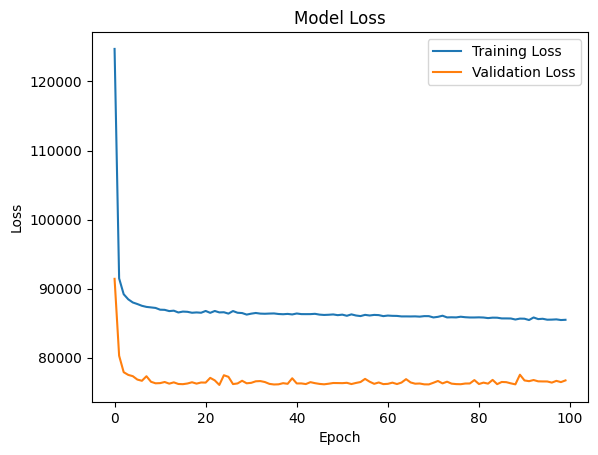

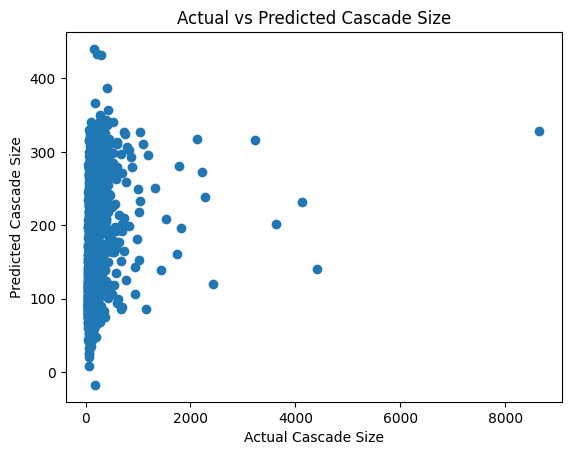

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.scatter(y_test, predictions)
plt.xlabel('Actual Cascade Size')
plt.ylabel('Predicted Cascade Size')
plt.title('Actual vs Predicted Cascade Size')
plt.show()


Defining the DeepHawkes Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the DeepHawkes model architecture
def build_deephawkes_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build the model
input_shape = (X_train_scaled.shape[1],)
deephawkes_model = build_deephawkes_model(input_shape)


Preparing Data for Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Training the Model

In [ ]:
# Train the DeepHawkes model
history = deephawkes_model.fit(X_train_scaled, y_train,
                                validation_data=(X_val_scaled, y_val),
                                epochs=100, batch_size=32,verbose=1)


Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 199648.8750 - mae: 195.0245 - val_loss: 175465.5469 - val_mae: 150.4952
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 68215.4297 - mae: 142.1157 - val_loss: 172123.6562 - val_mae: 148.8948
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78790.2891 - mae: 140.1742 - val_loss: 171173.9375 - val_mae: 148.3418
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78790.3281 - mae: 135.8165 - val_loss: 170563.2500 - val_mae: 152.2840
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 127098.6641 - mae: 143.5338 - val_loss: 170457.1094 - val_mae: 151.3116
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81663.0859 - mae: 135.9157 - val_loss: 171120.2656 - val_mae: 143.2200
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 102413.5547 - mae: 136.2195 - val_loss: 170196.3906 - val_mae: 153.3325
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85660.4609 -

Evaluating the Model

In [ ]:
# Evaluate the model
val_loss, val_mae = deephawkes_model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss (MSE): {val_loss:.4f}, Validation MAE: {val_mae:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69822.1094 - mae: 131.9563 
Validation Loss (MSE): 168667.6875, Validation MAE: 148.4056


In [ ]:

# Make predictions
predictions = deephawkes_model.predict(X_val_scaled)



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Display predictions
predictions_df = pd.DataFrame({'Actual': y_val, 'Predicted': predictions.flatten()})
print(predictions_df.head())


      Actual   Predicted
8         55  227.833664
4759      97  298.745544
3809      57  146.741501
4552      71  265.636536
4151      81  147.571655


In [ ]:
# Calculate performance metrics
mae = mean_absolute_error(y_val, predictions)
mse = mean_squared_error(y_val, predictions)

print(f"\nMean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")


Mean Absolute Error: 148.41
Mean Squared Error: 168667.69


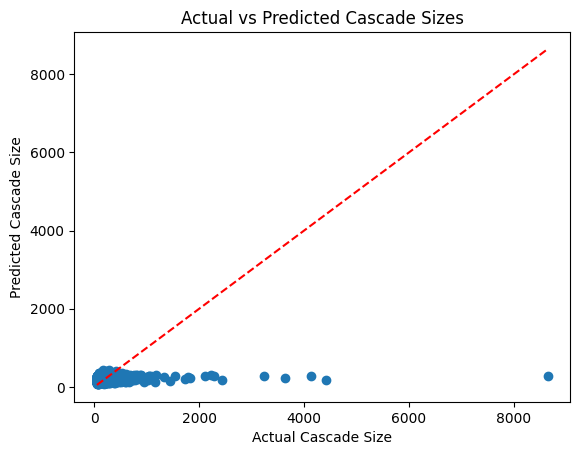

In [ ]:
import matplotlib.pyplot as plt

# Example for plotting actual vs predicted
plt.scatter(y_val, predictions)
plt.xlabel("Actual Cascade Size")
plt.ylabel("Predicted Cascade Size")
plt.title("Actual vs Predicted Cascade Sizes")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line for perfect predictions
plt.show()


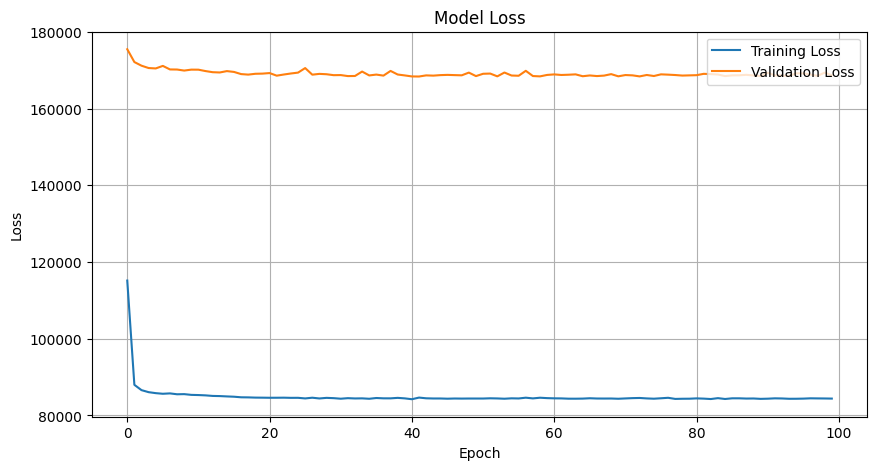

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()


Define the CasCN Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Define a simple Dense-based CasCN model (as Conv1D might not be suitable for your data)
def build_cas_dense_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model






In [ ]:
# Use the shape (2,) since there are only two features
input_shape = (X_train_scaled.shape[1],)  # (2,)
cas_cn_model = build_cas_dense_model(input_shape)

# Print the model summary
cas_cn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model and store the history
history_cas_cn = cas_cn_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=20, batch_size=32)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 108702.3359 - mae: 186.7361 - val_loss: 175791.2500 - val_mae: 145.8418
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58407.5586 - mae: 131.5727 - val_loss: 172045.0781 - val_mae: 150.4291
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85524.3984 - mae: 134.3816 - val_loss: 170943.7812 - val_mae: 151.4146
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96907.2812 - mae: 144.4949 - val_loss: 170569.9844 - val_mae: 148.8246
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96567.8750 - mae: 140.2310 - val_loss: 170721.9688 - val_mae: 146.6877
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91314.5859 - mae: 136.7665 - val_loss: 170514.8125 - val_mae: 146.5096
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79154.3359 - mae: 135.3743 - val_loss: 170468.9062 - val_mae: 145.3690
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89373.3281 - mae: 138.

In [ ]:
# Evaluate the model
val_loss, val_mae = cas_cn_model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss (MSE): {val_loss:.4f}, Validation MAE: {val_mae:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70594.7812 - mae: 137.2338
Validation Loss (MSE): 168472.6250, Validation MAE: 152.5626


In [ ]:
# Make predictions
cas_cn_predictions = cas_cn_model.predict(X_val_scaled)

# Display predictions
predictions_df_cas_cn = pd.DataFrame({'Actual': y_val, 'Predicted': cas_cn_predictions.flatten()})
print("CasCN Predictions:\n", predictions_df_cas_cn.head())

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
CasCN Predictions:
       Actual   Predicted
8         55  250.480255
4759      97  335.665649
3809      57  146.973984
4552      71  250.475876
4151      81  154.217331


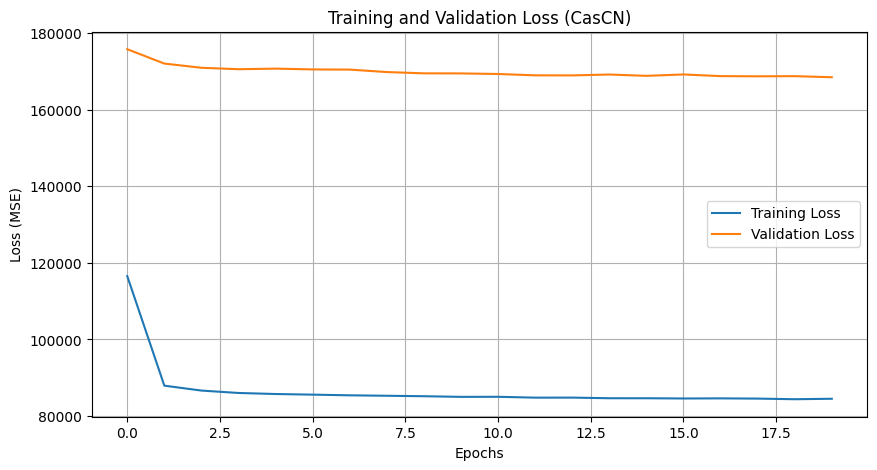

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_cas_cn.history['loss'], label='Training Loss')
plt.plot(history_cas_cn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (CasCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()



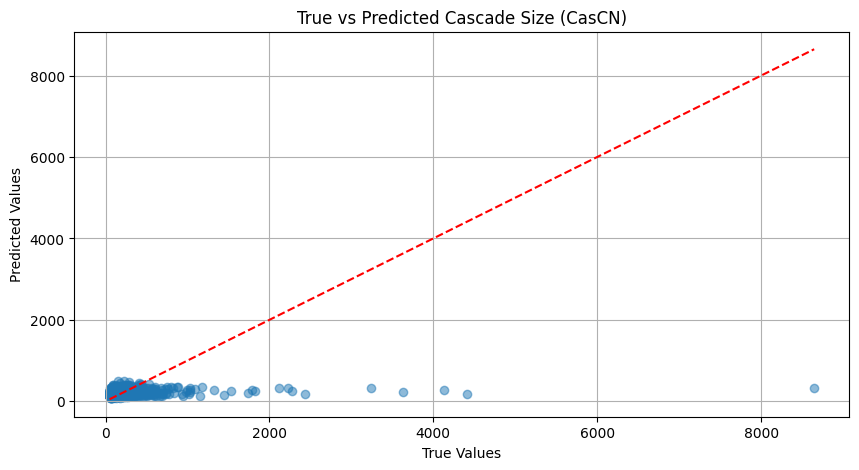

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(y_val, cas_cn_predictions.flatten(), alpha=0.5)
plt.title('True vs Predicted Cascade Size (CasCN)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line for perfect predictions
plt.grid()
plt.show()



TiDeH model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the TiDeH model architecture
def build_tideh_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Set input shape based on training data
input_shape = (X_train_scaled.shape[1],)  # Assuming two features
tideh_model = build_tideh_model(input_shape)

# Print model summary
tideh_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the TiDeH model and store the training history
history_tideh = tideh_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=20, batch_size=32)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 124885.7656 - mae: 193.6543 - val_loss: 175475.2969 - val_mae: 145.0312
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88734.5469 - mae: 141.6503 - val_loss: 171722.1875 - val_mae: 152.6628
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94154.7109 - mae: 138.6276 - val_loss: 171375.9062 - val_mae: 146.4205
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75988.6719 - mae: 131.8255 - val_loss: 170669.5312 - val_mae: 149.3088
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79042.4922 - mae: 134.2014 - val_loss: 170255.6250 - val_mae: 153.5265
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68240.1719 - mae: 130.1805 - val_loss: 170209.5156 - val_mae: 152.6182
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60202.5312 - mae: 128.4986 - val_loss: 170178.5156 - val_mae: 151.2565
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100429.9453 - mae: 139

In [ ]:
# Evaluate the model on the validation data
val_loss, val_mae = tideh_model.evaluate(X_val_scaled, y_val, verbose=1)

# Print evaluation results
print(f"Validation Loss (MSE): {val_loss:.4f}, Validation MAE: {val_mae:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69758.1094 - mae: 127.3737 
Validation Loss (MSE): 169574.1875, Validation MAE: 144.2203


In [ ]:
# Make predictions on the validation set
tideh_predictions = tideh_model.predict(X_val_scaled)

# Display a DataFrame with actual vs. predicted values
import pandas as pd
predictions_df_tideh = pd.DataFrame({'Actual': y_val, 'Predicted': tideh_predictions.flatten()})
print("TiDeH Predictions:\n", predictions_df_tideh.head())



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
TiDeH Predictions:
       Actual   Predicted
8         55  207.955170
4759      97  276.606354
3809      57  142.115250
4552      71  227.037018
4151      81  151.072144


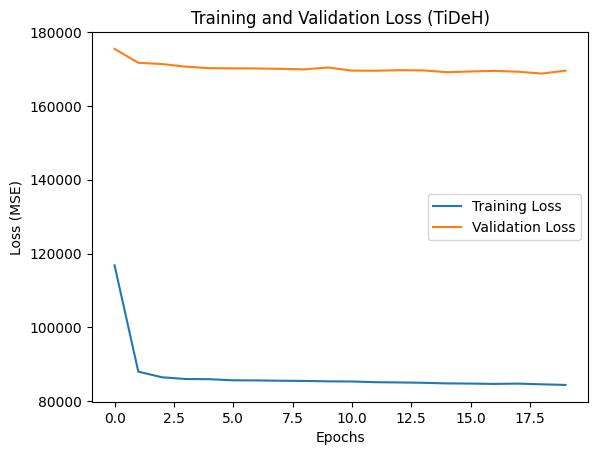

In [ ]:
# Plot the training and validation loss
plt.plot(history_tideh.history['loss'], label='Training Loss')
plt.plot(history_tideh.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (TiDeH)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


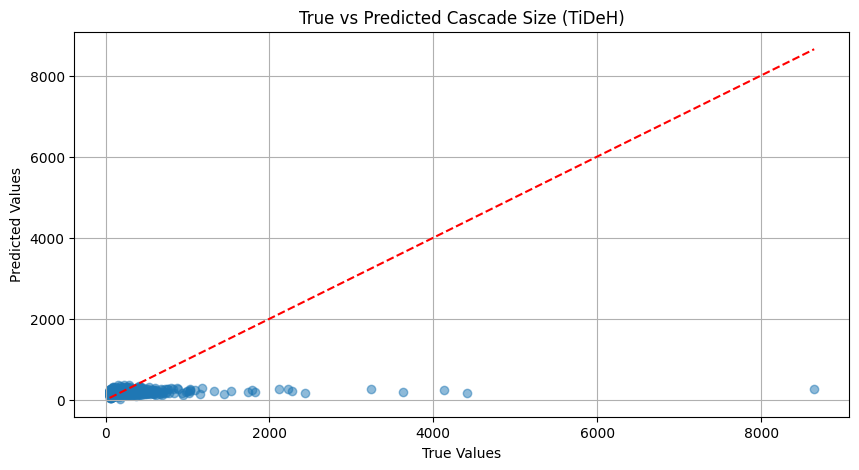

In [ ]:
# Plot true vs predicted values for visual evaluation
plt.figure(figsize=(10, 5))
plt.scatter(y_val, tideh_predictions.flatten(), alpha=0.5)
plt.title('True vs Predicted Cascade Size (TiDeH)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line for perfect predictions
plt.grid()
plt.show()
